In [2]:
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00


In [3]:
!pip install latex


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7588 sha256=930759375393f866bde1440e114576c7dbb070d0e5a9e8edf7eb795b0ac7330a
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=e1828317d1071713181760c237c0529676265694f779d7ffccb04c381f2c9f4d
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2763 sha256=b47e0cc9adeab48295e4cff3853d6927780b5f18d564bc196030b910fff496f9
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.w

In [4]:
pip install seaborn

In [5]:
import seaborn as sns

In [6]:
!pip install transformers

In [29]:
L=sns.color_palette("colorblind")

In [7]:
QK=r"$Q^{T}K$"

In [45]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import torch
from google.colab import files
import numpy as np


# returns Bm, Vm whose meaning is this:
#
# x_i (t+1) = x_i(t) + \sum_m \sum_j 1/Z_{i,m} exp(<x_i, Bm x_j>) Vm x_j
#
# Here tokens are normalized so that ||x_i||=\sqrt{d_model} (i.e. not on a unit sphere).
#
def albert_get_BV(al_model, head_idx=0):
    al_transfo = al_model.encoder;
    al_layer = al_transfo.albert_layer_groups[0].albert_layers[0];
    al_attention = al_layer.attention;

    # These matrices that act on token x (row-vector) by x \times WQ etc
    WQ = al_attention.query.weight.T;
    WV = al_attention.value.weight.T;
    WK = al_attention.key.weight.T;
    D = al_attention.dense.weight.T;

    dk = al_attention.attention_head_size;
    dmodel = al_attention.hidden_size;
    m = head_idx;


    WQm = WQ[:, (dk*m):(dk*m + dk)]; WKm = WK[:, (dk*m):(dk*m + dk)];
    WVm = torch.zeros(dmodel,dmodel);
    WVm[:, (dk*m):(dk*m + dk)] = WV[:, (dk*m):(dk*m + dk)];

    # bilinear form matrix
    b_mtx = torch.matmul(WQm, WKm.T); b_mtx = 0.5* (b_mtx + b_mtx.T) / math.sqrt(dk);

    # Convert value matrix to a matrix acting on tokens as column vectors:
    value_mtx = torch.matmul(WVm, D).T;

    return b_mtx.clone().detach(), value_mtx.clone().detach();


def plot_B_spectra(al_model):
    assert(al_model.config.num_attention_heads == 16) | (al_model.config.num_attention_heads == 1) ;

    print('Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)')

    heads = 16;
    minx = 0; maxx = 0;

    betas = [];
    dmodel = al_model.config.hidden_size;
    assert(dmodel == 2048);

    for i in range(heads):
        B, _ = albert_get_BV(al_model, i);
        eigs = torch.linalg.eigvalsh(B);
        eigs=eigs.numpy()

        plt.style.use('seaborn-whitegrid')
        plt.hist(eigs,bins=np.linspace(-0.5,0.5,num=100),color=L[3])
        plt.yscale("log")
        plt.ylabel('Count')
        plt.xlabel('Spectrum of '+str(QK)+' of Head '+str(i)+'. ', fontsize=14)
# Show the plot
        plt.tight_layout()
        base_filename = "eigs_QK_" + "{}.pdf".format(i+1)
        plt.savefig(base_filename,
                    format='pdf',
                    bbox_inches='tight')
        files.download(base_filename)
        plt.show()
        plt.clf()
        plt.close()


        minx = min(minx, eigs.min());
        maxx = max(maxx, eigs.max());

        eff_beta = math.sqrt((B.flatten()**2).sum() * dmodel);
        betas += [eff_beta,];


    #  This is computed as that beta which would yield the same typical RMSE value (for a pair of indep isotropic token)
    #  in the model with exp(<x_i, x_j>\beta / d_model), where again x_i has N(0,1) coordinates.
    print('Effective betas = ', betas)









def plot_V_spectra(al_model):
    assert(al_model.config.num_attention_heads == 16) | (al_model.config.num_attention_heads == 1) ;

    print('Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)')

    if al_model.config.num_attention_heads == 16:
        heads = 16;
        #fig, axes = plt.subplots(4,4);
        #axes = axes.flatten();
    else:
        raise AssertionError('num heads');

    minx = 0; maxx = 0;

    dmodel = al_model.config.hidden_size;
    assert(dmodel == 2048);


    for i in range(heads):
        _, V = albert_get_BV(al_model, i);
        eigs = torch.linalg.eigvals(V);
        eigs = eigs[eigs.abs() > 1e-4];

        if heads == 16:
            print(f'Head = {i}, non-zero eigs = {len(eigs)}')
            #assert len(eigs) == 128;

        minx = min(minx, eigs.real.min());
        maxx = max(maxx, eigs.real.max());
        plt.style.use('seaborn-whitegrid')

        plt.figure()
        #plt.plot(eigs.real, eigs.imag, 'k.');

        label_size = 15
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)

        plt.grid(color='silver', linestyle=':', linewidth=0.15, alpha=0.90, zorder=3)
        plt.gca().set_axisbelow(True)


        #print(eigs.real.shape)
        plt.scatter([x for x in eigs.real],
                    [x for x in eigs.imag],
                    color=L[3],
                    linewidth=0.2,
                    edgecolors='black')
        title = 'Eigenvalues of value matrix for head %s' % int(i+1)
        plt.xlim(-2.25-0.1, 1.5+0.1)
        plt.ylim(-1.5-0.1, 1.5+0.1)
        plt.xlabel(title,fontsize=14)
        plt.gca().set_aspect('equal', adjustable='box')
        #axes[i].set_ylim(0,8);

        base_filename = "eigs" + "{}.pdf".format(i+1)
        print(i)
        plt.savefig(base_filename,
                    dpi=400,
                    format='pdf',
                    bbox_inches='tight')
        files.download(base_filename)
        plt.show()
        plt.clf()
        plt.close()


Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)
Head = 0, non-zero eigs = 128
0


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

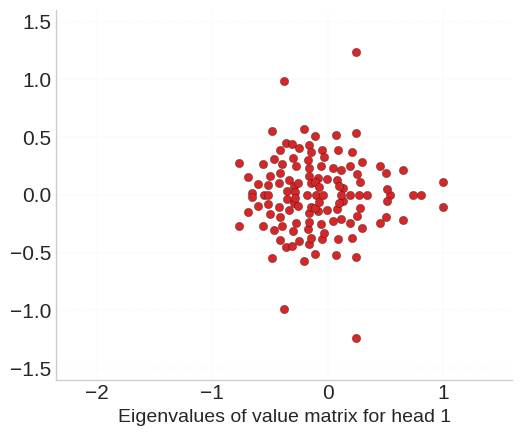

Head = 1, non-zero eigs = 128
1


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

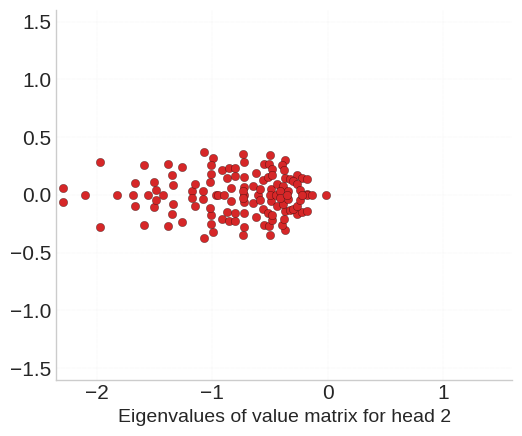

Head = 2, non-zero eigs = 128
2


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

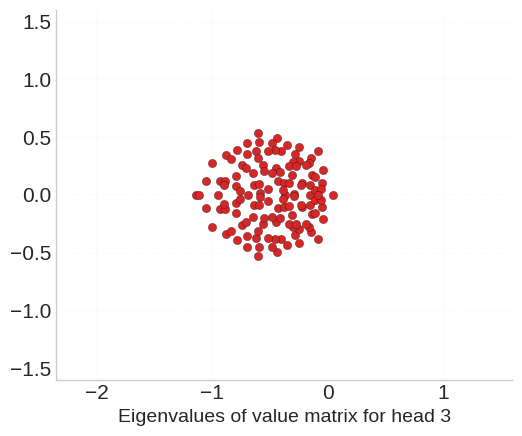

Head = 3, non-zero eigs = 128
3


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

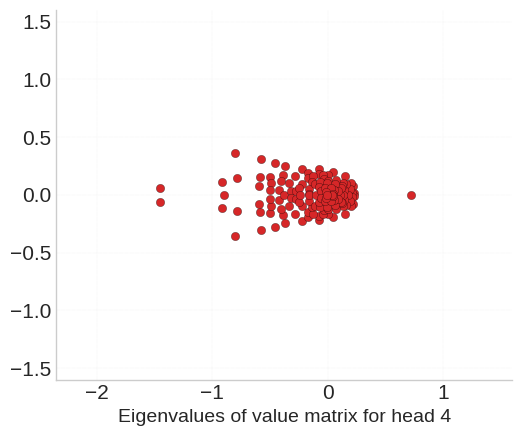

Head = 4, non-zero eigs = 128
4


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

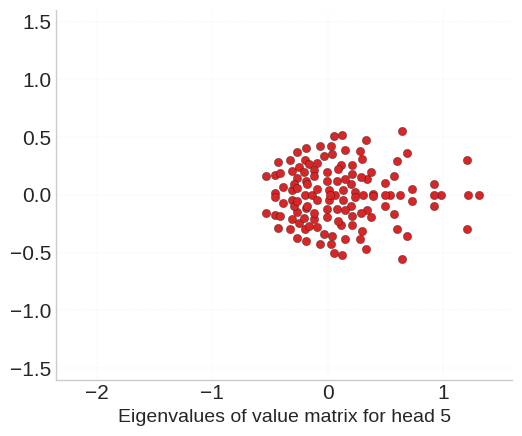

Head = 5, non-zero eigs = 128
5


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

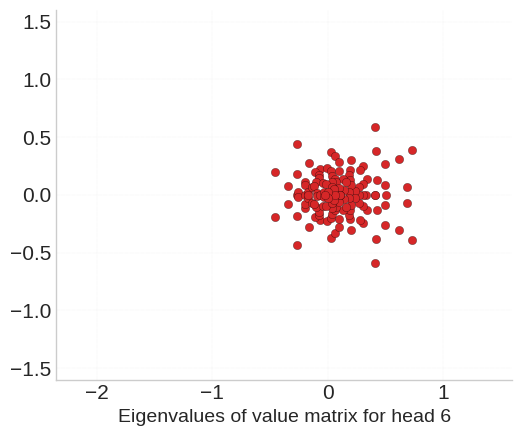

Head = 6, non-zero eigs = 128
6


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

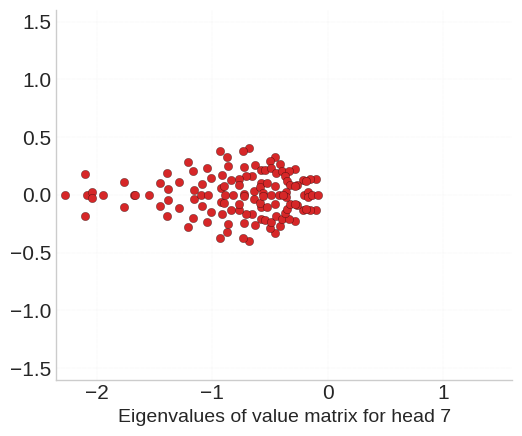

Head = 7, non-zero eigs = 128
7


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

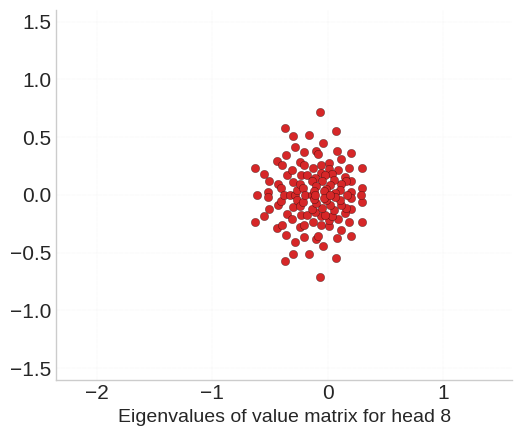

Head = 8, non-zero eigs = 128
8


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

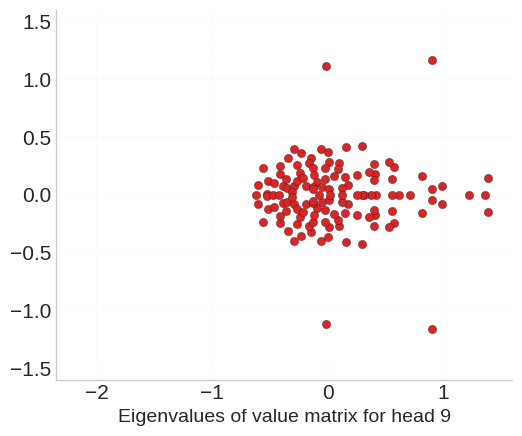

Head = 9, non-zero eigs = 128
9


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

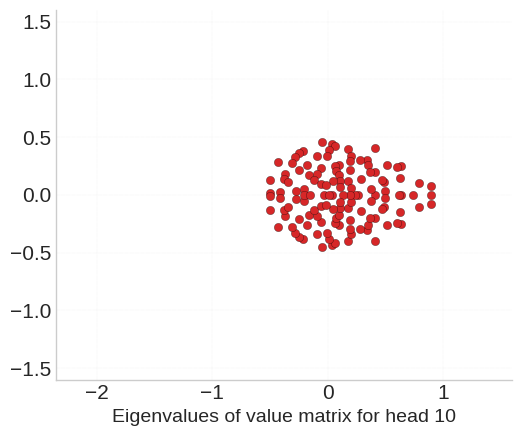

Head = 10, non-zero eigs = 128
10


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

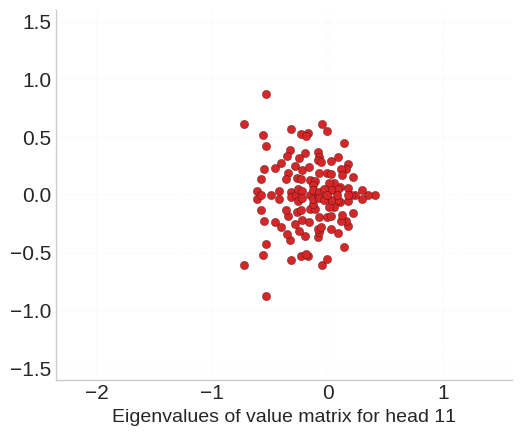

Head = 11, non-zero eigs = 128
11


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

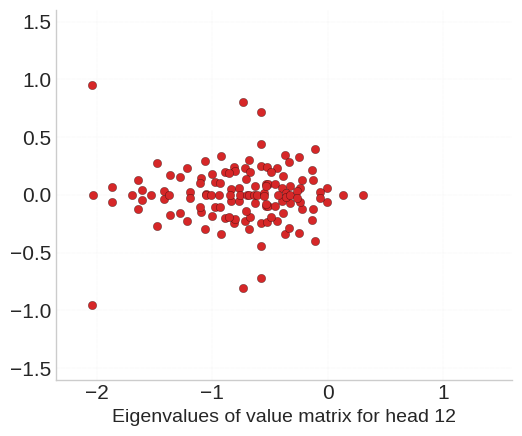

Head = 12, non-zero eigs = 128
12


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

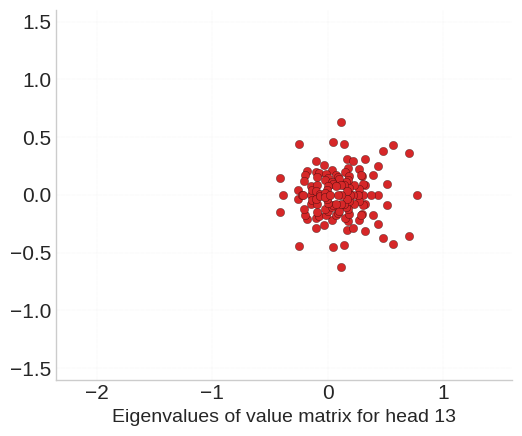

Head = 13, non-zero eigs = 128
13


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

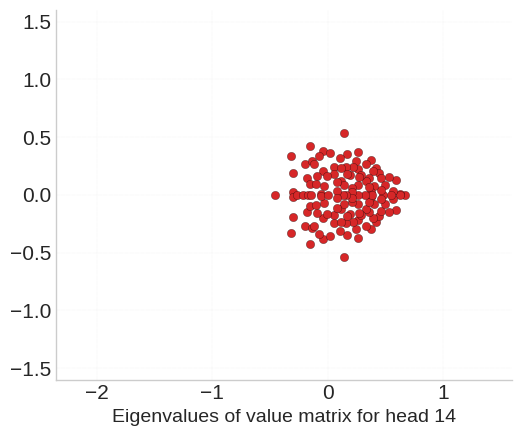

Head = 14, non-zero eigs = 128
14


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

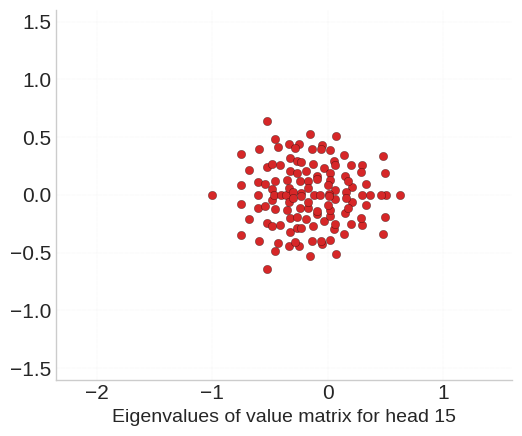

Head = 15, non-zero eigs = 128
15


<ipython-input-41-ecffc14e0299>:126: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

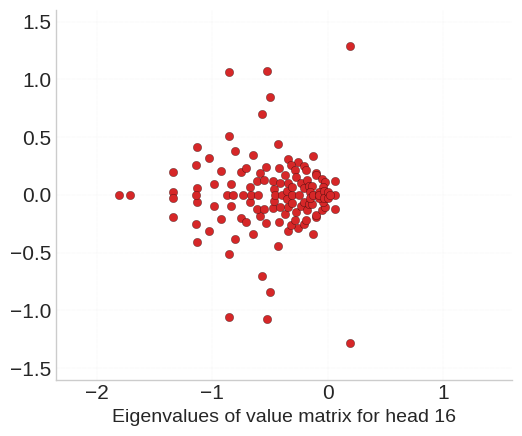

In [42]:
from transformers import AlbertTokenizer, AlbertModel
#tokenizer = AlbertTokenizer.from_pretrained('albert-xlarge-v2')
al_model = AlbertModel.from_pretrained("albert-xlarge-v2")

plot_V_spectra(al_model)

Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)


<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

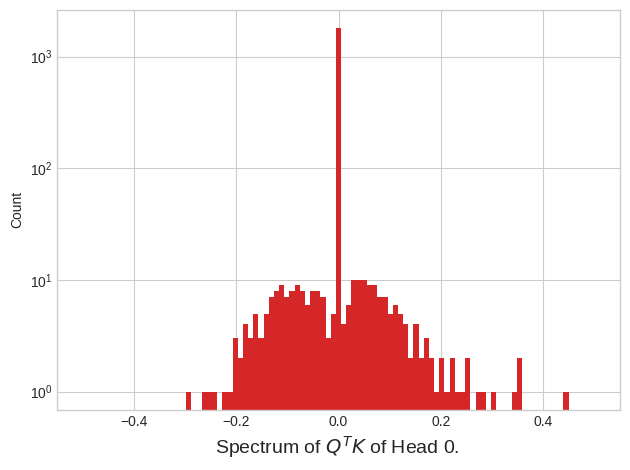

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

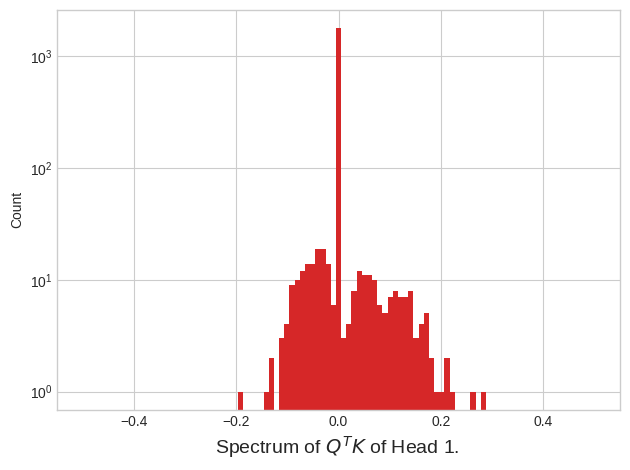

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

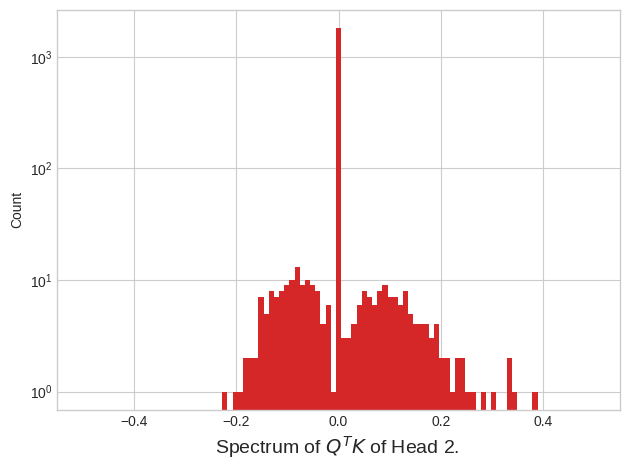

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

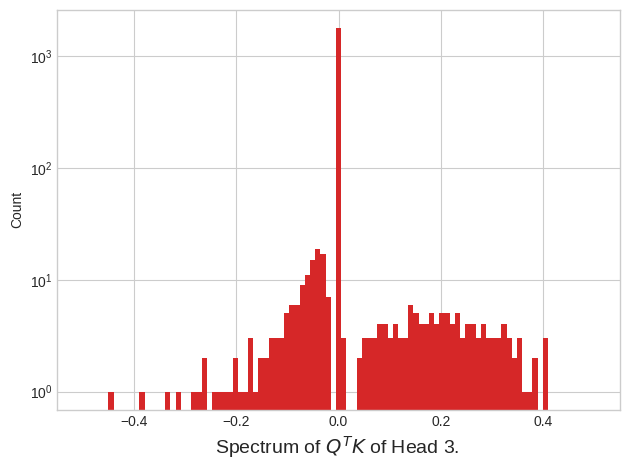

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

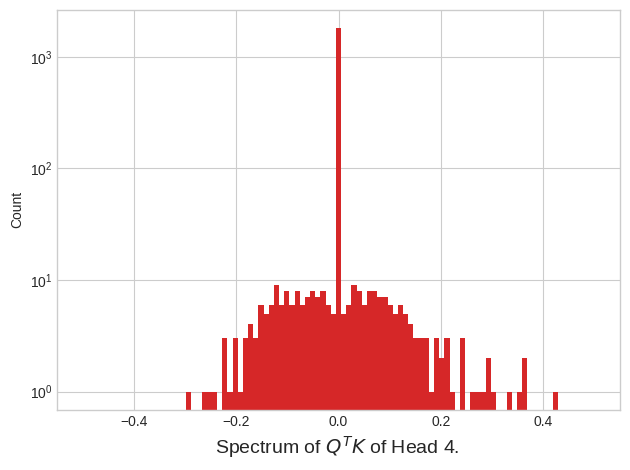

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

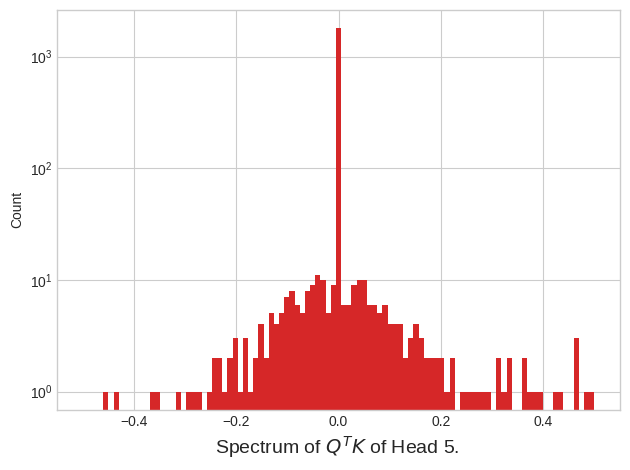

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

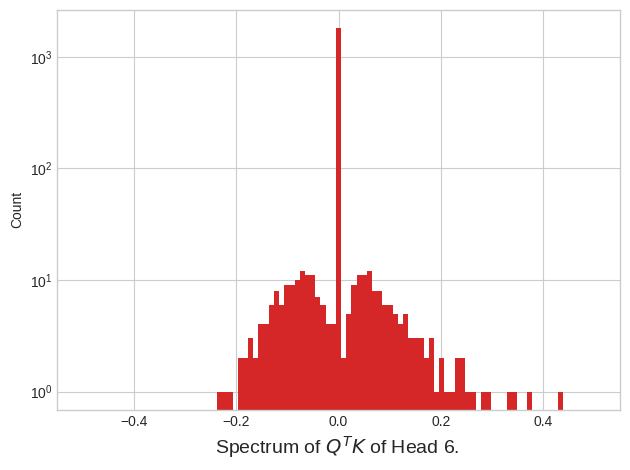

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

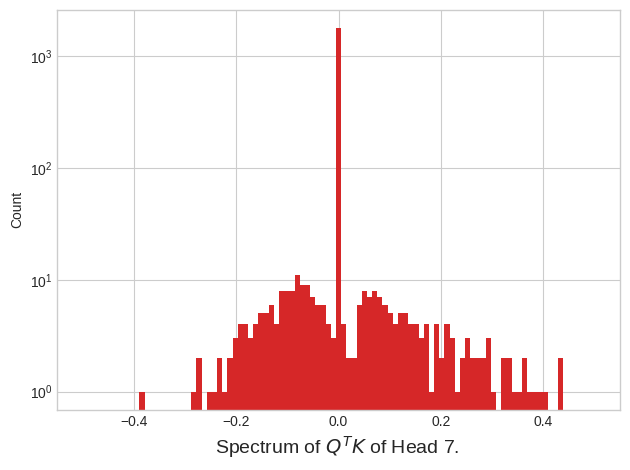

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

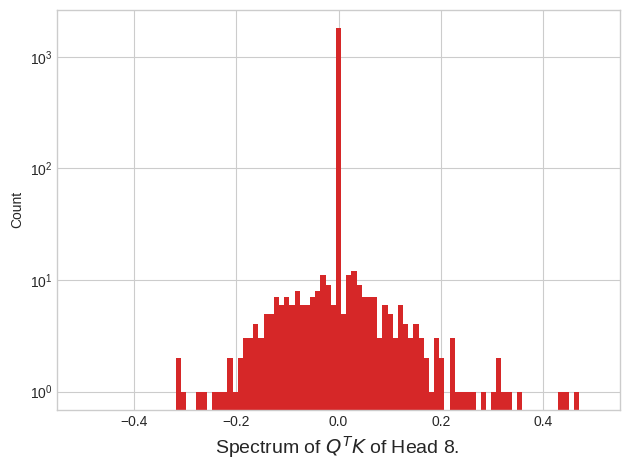

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

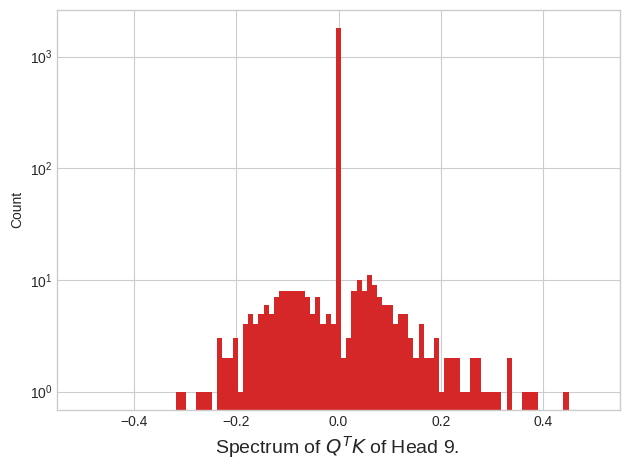

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

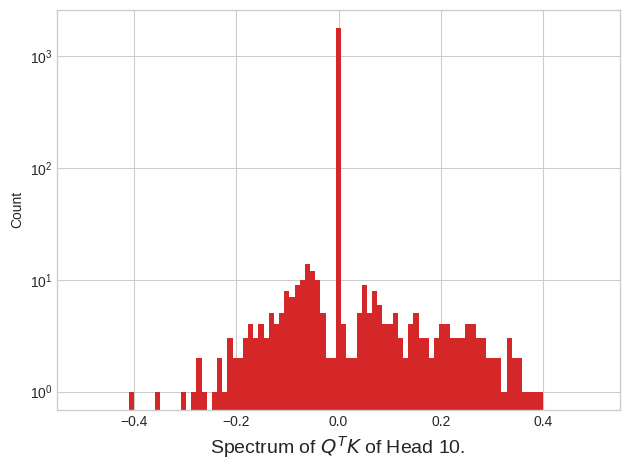

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

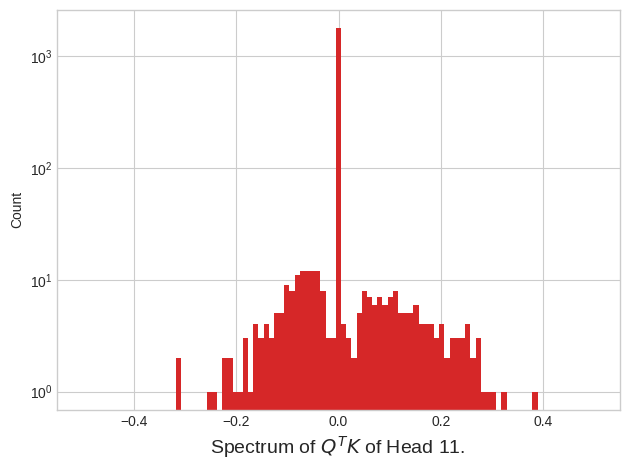

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

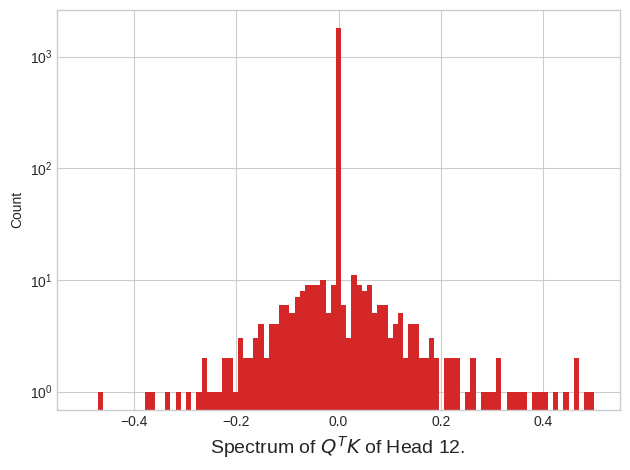

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

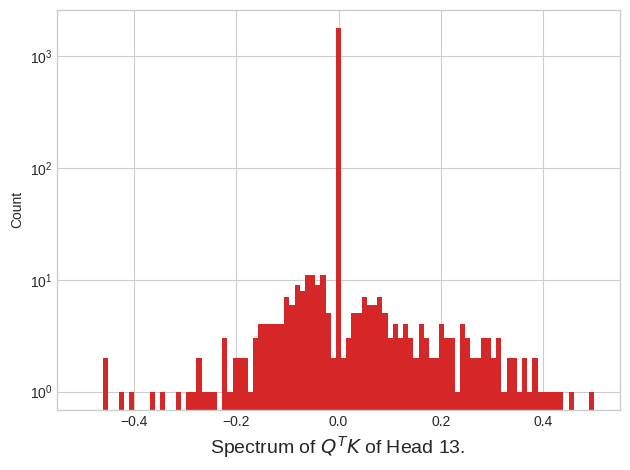

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

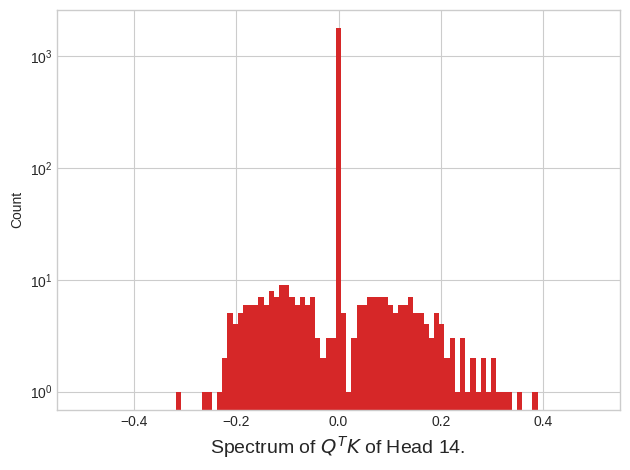

<ipython-input-45-3833b2c19fc0>:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

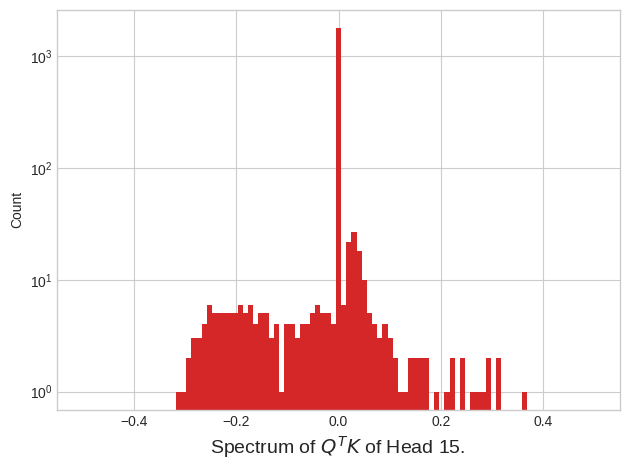

Effective betas =  [92.31365837966503, 64.71370996792334, 88.04151630764886, 130.27179370214796, 94.30876193718694, 121.08933862932567, 84.04051176181342, 116.73290576809309, 98.38982476449229, 101.03746017876242, 119.22073638581084, 97.41883641011115, 121.41158289445657, 137.4381963374811, 107.23471081289398, 104.95472424157475]


In [46]:
plot_B_spectra(al_model)

In [11]:
files.download("eigs11.pdf")
files.download("eigs12.pdf")
files.download("eigs13.pdf")
files.download("eigs14.pdf")
files.download("eigs15.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
for i in range(1,16):
  files.download("eigs"+str(i)+".pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>